<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Titillium+Web:ital,wght@0,200;0,300;0,400;0,600;0,700;0,900;1,200;1,300;1,400;1,600;1,700&display=swap" rel="stylesheet">
<div class="box" style="padding: 10px; margin: 10px 0; background-color: gray; color: white; border-radius: 5px; font-size: 15px;">
  <table style="padding: 10px; margin: auto auto; background-color: gray;  border-radius: 5px; font-size: 15px;">
      <tr>
          <th colspan='2'><h1 style="text-align: center">
Machine Learning </br>
</h1>
<h2 style="text-align: center">
Course Assignment Two </br>
</h2>
</th>
<tr>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Github:</td>
      <td><a href="https://github.com/AliNikkhah2001/MachineLearning01" target="_blank">https://github.com/AliNikkhah2001/MachineLearning01</a></td>
    </tr>
  </table>
</div>



# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

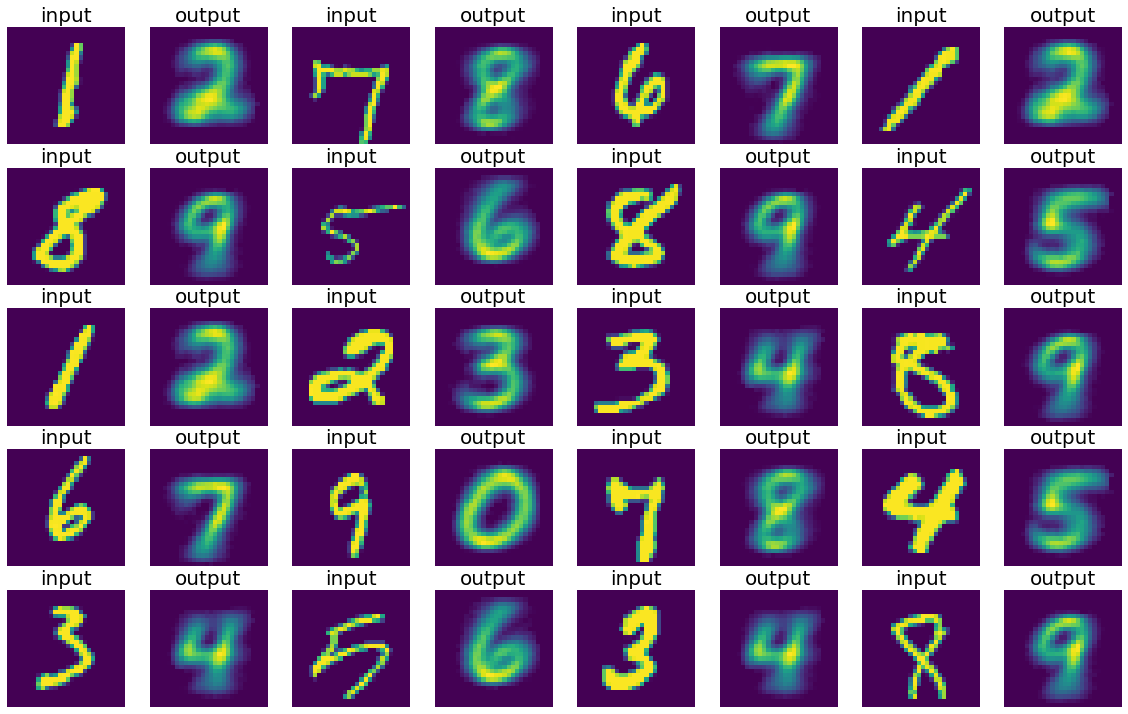

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## ae_helper and libraries import

In [8]:
"""
AUTHOR:         Ahmad Salimi (https://github.com/ahmadsalimi)
"""


from typing import Tuple

from sklearn.datasets import fetch_openml
import numpy as np
import os
import torch
from tqdm import tqdm


def get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Downloads the MNIST data and processes the data for autoencoder problem.
    
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,
            output images (input + 1), and the label of input images
    """
    X, y = fetch_openml('mnist_784', return_X_y=True, cache=True)
    X, y = X.values, y.values
    X = X.reshape(-1, 28, 28).astype('float32') / 255.0
    y = y.astype(int)

    Y = np.zeros_like(X)
    ind = y.argsort()
    X, y = X[ind], y[ind]

    c = 0
    for i in range(10):
        s = (y == i).sum()
        ss = (y == (i + 1) % 10).sum()
        if s <= ss:
            Y[c:c+s] = X[c+s:c+2*s]
        elif i < 9:
            Y[c:c+ss] = X[c+s:c+s+ss]
            Y[c+ss:c+s] = X[c+s:c+2*s-ss]
        else:
            Y[c:c+ss] = X[:ss]
            Y[c+ss:c+s] = X[:s-ss]
        c += s

    current_state = np.random.get_state()

    np.random.seed(10)
    ind = np.random.permutation(X.shape[0])
    X, Y, y = X[ind], Y[ind], y[ind]

    np.random.set_state(current_state)

    return X, Y, y

def init_mnist_subset_directories(mnist_dataset, dataset_path, subset_size=5000):
    mnist_subset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:subset_size])

    os.mkdir(dataset_path)
  
    for idx, (x, y) in enumerate(tqdm(mnist_subset)):
        label_path = os.path.join(dataset_path, str(y))
        if not os.path.exists(label_path):
            os.mkdir(label_path)
        torch.save(x, os.path.join(label_path, 'data_'+str(idx)+'.pth'))

from sklearn.model_selection import train_test_split
X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt



# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64x7x7
            nn.ReLU(),
            nn.Flatten(), # 64*7*7
            nn.Linear(64*7*7, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
class AutoencoderV1(nn.Module):
    def __init__(self):
        super(AutoencoderV1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1), # 64x14x14
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 128x7x7
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 256x4x4
            nn.ReLU(),
            nn.Flatten(), # 256*4*4
            nn.Linear(256*4*4, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 256*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1), # 128x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 64x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class AutoencoderV2(nn.Module):
    def __init__(self):
        super(AutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1), # 64x14x14
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 128x7x7
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 256x4x4
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), # 512x2x2
            nn.ReLU(),
            nn.Flatten(), # 512*2*2
            nn.Linear(512*2*2, 512),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 512*2*2),
            nn.ReLU(),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), # 256x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), # 128x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 64x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [10]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)
# Load and preprocess the MNIST data
X, Y, _ = get_data()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).unsqueeze(1)
Y_tensor = torch.tensor(Y).unsqueeze(1)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.
## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [12]:
# Function to train the model with early stopping
def train_model(model, train_loader, val_loader, num_epochs=50, patience=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{model.__class__.__name__}_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()





In [13]:

# Initialize the model, loss function, and optimizer
model = Autoencoder()


In [14]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load and preprocess the MNIST data
X, Y, _ = get_data()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).unsqueeze(1)
Y_tensor = torch.tensor(Y).unsqueeze(1)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
 
# Split the data into training and validation sets
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor, Y_tensor), [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch [1/20], Train Loss: 0.0627, Val Loss: 0.0559
Epoch [2/20], Train Loss: 0.0553, Val Loss: 0.0551
Epoch [3/20], Train Loss: 0.0547, Val Loss: 0.0548
Epoch [4/20], Train Loss: 0.0545, Val Loss: 0.0547
Epoch [5/20], Train Loss: 0.0543, Val Loss: 0.0547
Epoch [6/20], Train Loss: 0.0542, Val Loss: 0.0547
Epoch [7/20], Train Loss: 0.0540, Val Loss: 0.0547
Epoch [8/20], Train Loss: 0.0539, Val Loss: 0.0548
Epoch [9/20], Train Loss: 0.0537, Val Loss: 0.0549
Epoch [10/20], Train Loss: 0.0535, Val Loss: 0.0550
Early stopping triggered


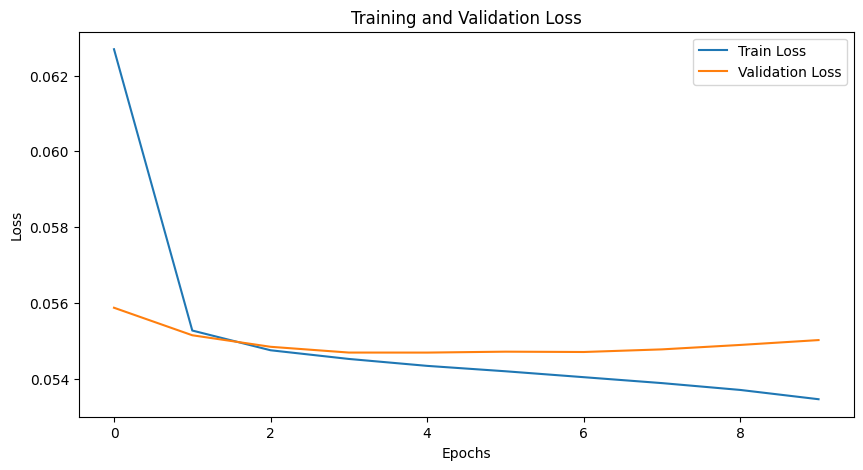

In [17]:

train_model(model, train_loader, val_loader, num_epochs=20, patience=5)

torch.save(model.state_dict(), 'autoencoder1.pth')


Epoch [1/50], Train Loss: 0.0606, Val Loss: 0.0551
Epoch [2/50], Train Loss: 0.0547, Val Loss: 0.0546
Epoch [3/50], Train Loss: 0.0544, Val Loss: 0.0545
Epoch [4/50], Train Loss: 0.0542, Val Loss: 0.0545
Epoch [5/50], Train Loss: 0.0541, Val Loss: 0.0545
Epoch [6/50], Train Loss: 0.0540, Val Loss: 0.0545
Epoch [7/50], Train Loss: 0.0539, Val Loss: 0.0545
Epoch [8/50], Train Loss: 0.0538, Val Loss: 0.0546
Early stopping triggered


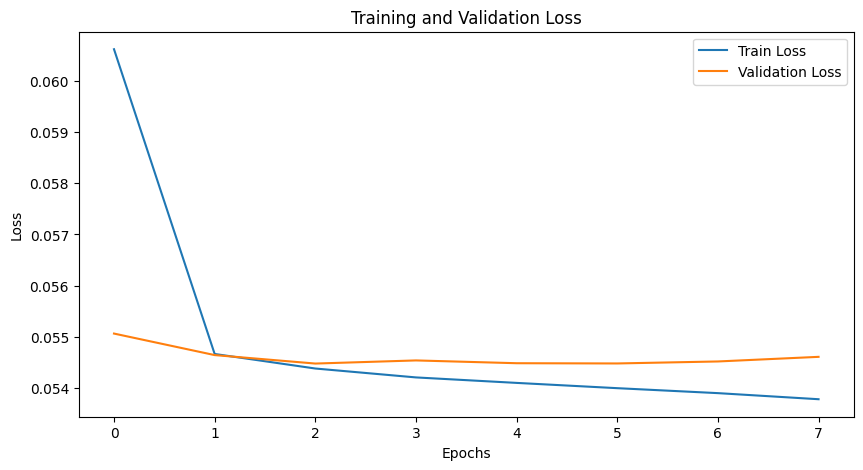

In [18]:

# Initialize the model, loss function, and optimizer
modelV1 = AutoencoderV1()

# Initialize the model, loss function, and optimizer
modelV2 = AutoencoderV2()


train_model(modelV1, train_loader, val_loader, num_epochs=50, patience=5)

torch.save(model.state_dict(), 'autoencoderV1.pth')



## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

Plotting images for Autoencoder1


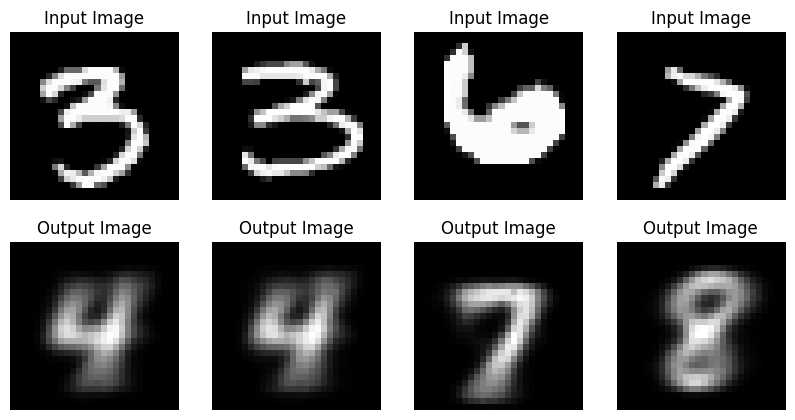

Plotting images for AutoencoderV1


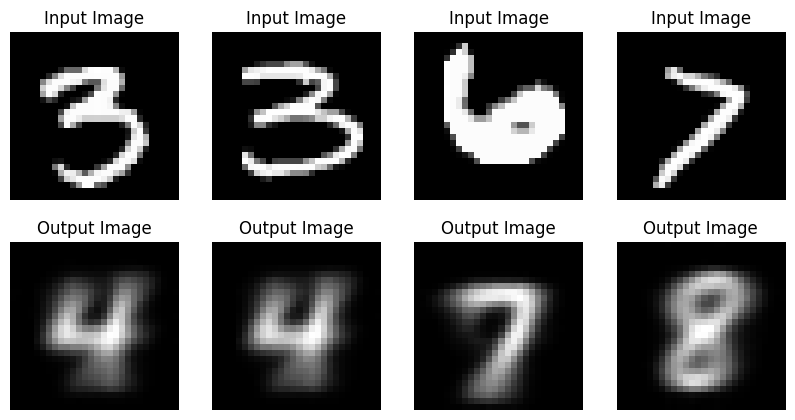

In [19]:
# Function to generate the next digit image
def generate_next_digit(model, input_image):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0).float().to(device)
        output_image = model(input_tensor).squeeze().cpu().numpy()
    return output_image

# Plot 4 input and output images for each model
def plot_images(model, X, num_images=4):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        input_image = X[i]
        output_image = generate_next_digit(model, input_image)
        
        # Plot input image
        plt.subplot(2, num_images, i + 1)
        plt.title('Input Image')
        plt.imshow(input_image, cmap='gray')
        plt.axis('off')
        
        # Plot output image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.title('Output Image')
        plt.imshow(output_image, cmap='gray')
        plt.axis('off')
    
    plt.show()
# Load the best models
modelV1.load_state_dict(torch.load('AutoencoderV1_best.pth'))

# Plot images for the original, model_v1, and model_v2
print("Plotting images for Autoencoder1")
plot_images(model, X)

print("Plotting images for AutoencoderV1")
plot_images(modelV1, X)

In [20]:

def plot_images(model, X, num_images=8):
    plt.figure(figsize=(48, 32))
    for i in range(num_images):
        input_image = X[i]
        output_image = generate_next_digit(model, input_image)
        
        # Plot input image
        plt.subplot(4, num_images, i + 1)
        plt.imshow(input_image, cmap='viridis')
        plt.title('input')
        plt.axis('off')
        
        # Plot output image
        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(output_image, cmap='viridis')
        plt.title('output')
        plt.axis('off')
    
    plt.show()


# Final Result Illustration

Plotting images for Autoencoder initial


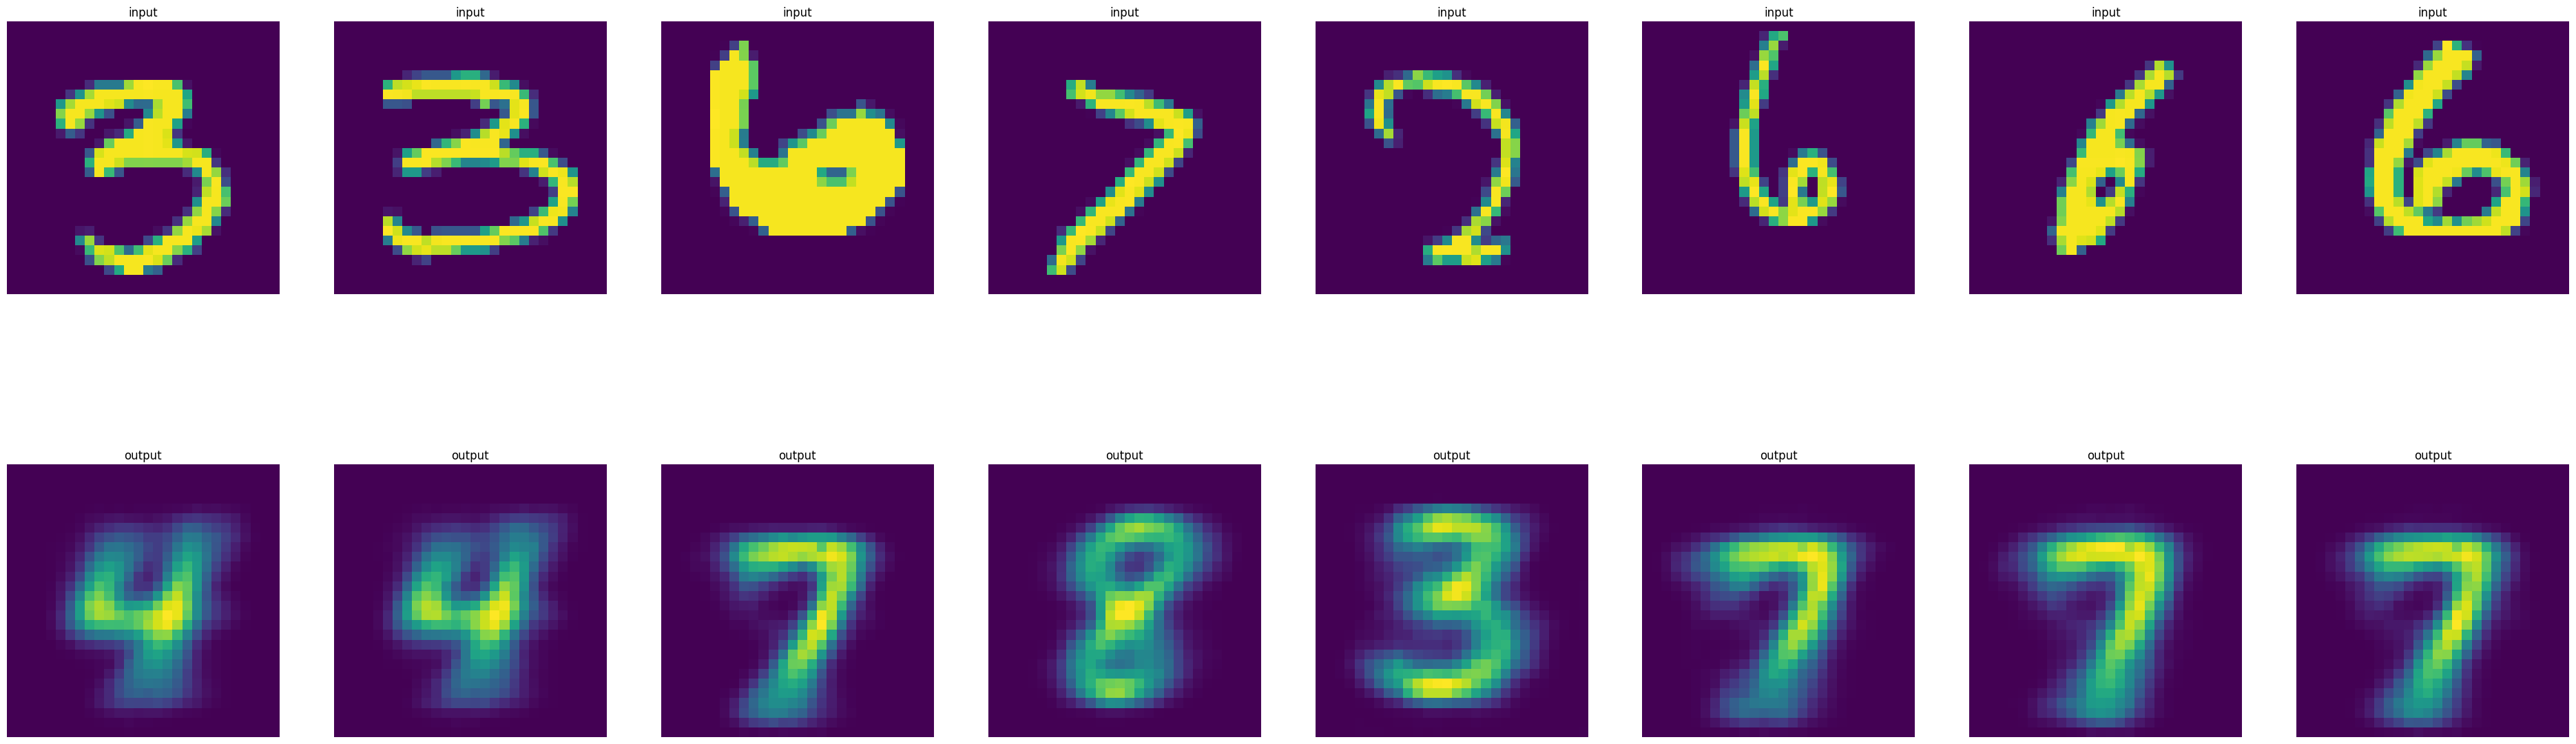

Plotting images for AutoencoderV1


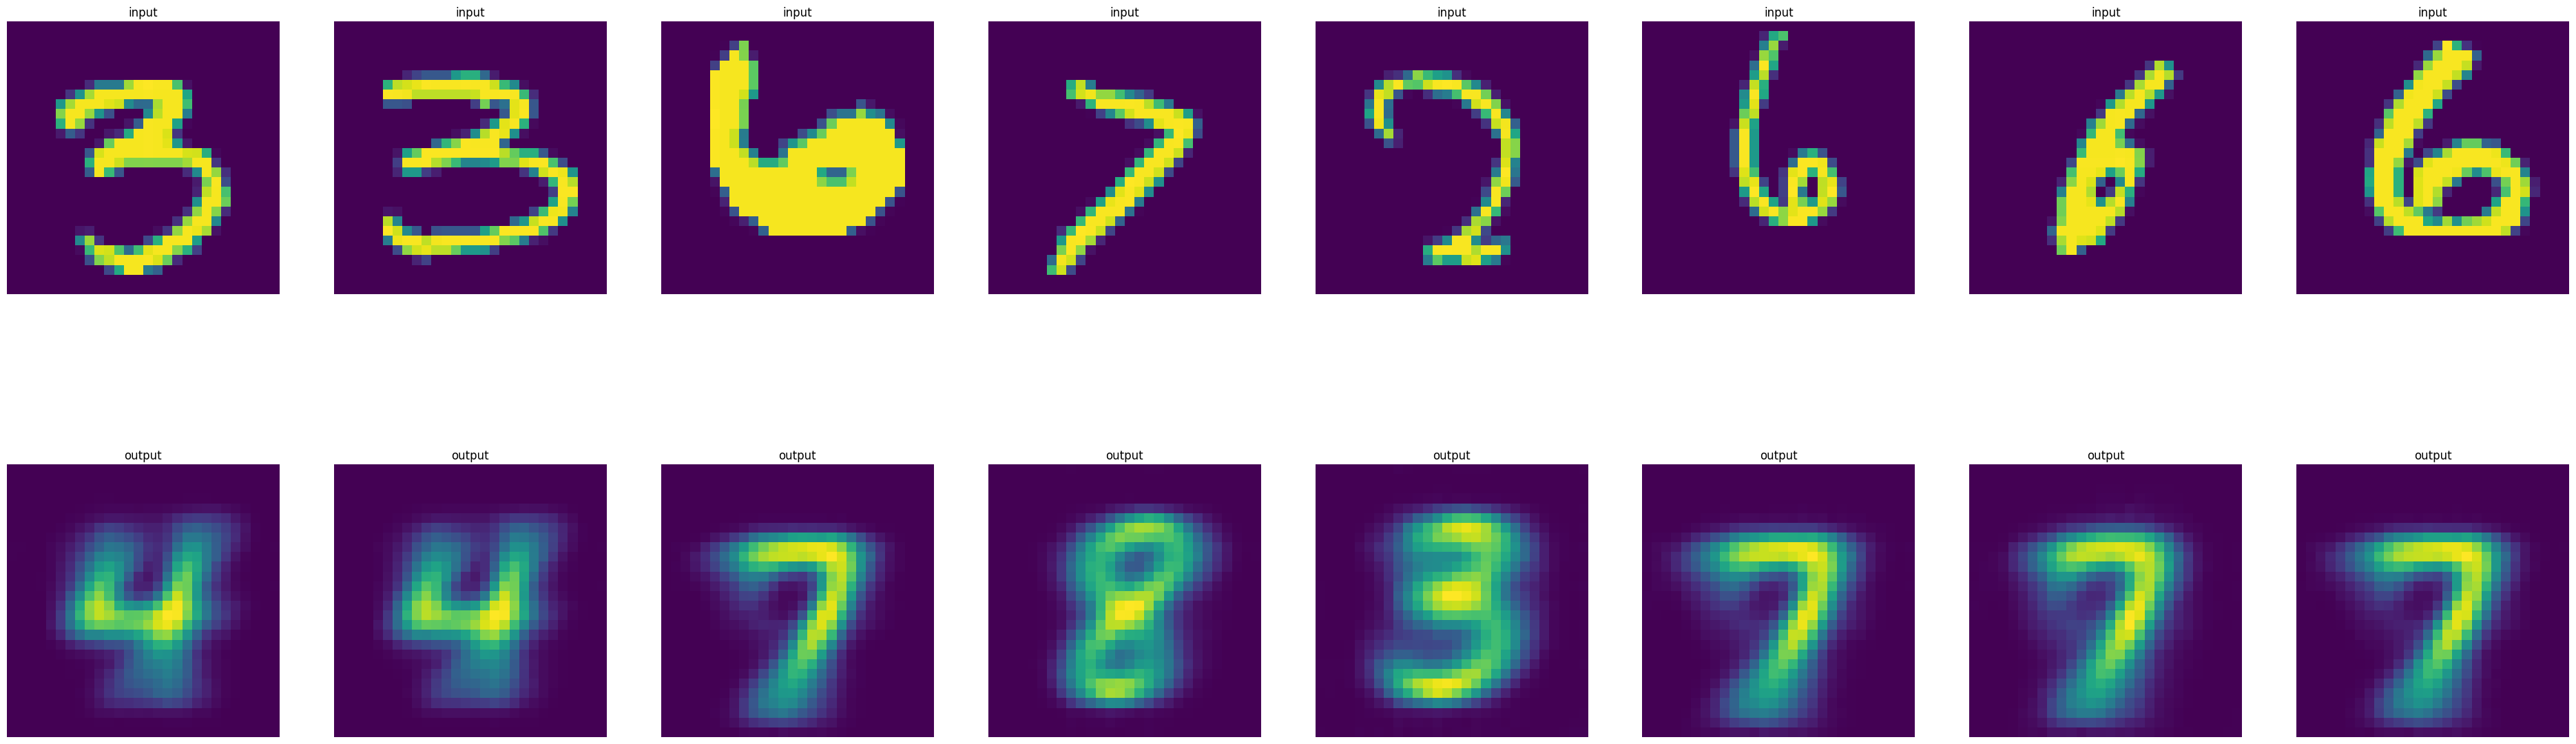

In [21]:
print("Plotting images for Autoencoder initial")
plot_images(model, X, num_images=8)

print("Plotting images for AutoencoderV1")
plot_images(modelV1, X, num_images=8)

### Comparison of Autoencoder Models: Shallow Model vs. Deep Model (AutoencoderV1)

#### 1. Output Generation Results
- **Shallow Model**: The shallow autoencoder model produces outputs that are recognizable as the next digit, but there is noticeable blurriness in the generated images. The structure of the digits is preserved to an extent, but fine details are often lost.
- **Deep Model (AutoencoderV1)**: The deeper autoencoder (AutoencoderV1) model generates outputs with less blurriness compared to the shallow model. The digits are more clearly defined, and the transitions between pixels are smoother, resulting in higher-quality images.

#### 2. Accuracy
- **Shallow Model**: While the shallow model can learn the general shape of the next digit, its accuracy is limited by its simpler architecture. The model struggles with preserving finer details and producing sharp images, leading to lower overall accuracy in digit generation.
- **Deep Model (AutoencoderV1)**: The deeper architecture of AutoencoderV1 allows it to capture more complex features and patterns in the data. This results in higher accuracy in generating the next digit, as the model can better understand the underlying structure of the digits.

#### 3. Blurriness
- **Shallow Model**: The outputs from the shallow model exhibit significant blurriness. This is due to the limited capacity of the model to learn detailed features, resulting in smoother transitions and less sharp edges in the generated images.
- **Deep Model (AutoencoderV1)**: The deep model produces less blurry images, with more defined edges and clearer distinctions between different parts of the digit. The increased depth and complexity of the model enable it to learn more detailed representations, reducing the blurriness in the outputs.


Overall, the deeper autoencoder (AutoencoderV1) outperforms the shallow model in terms of output quality, accuracy, and reduction of blurriness. The deeper architecture allows the model to learn more complex features, resulting in higher-quality and more accurate digit generation. However, this comes at the cost of increased computational resources and longer training times.

